In [60]:
# Importing required libraries

!pip install matplotlib opencv-python-headless
!pip install editdistance
import os
import json
import cv2
from PIL import Image, ImageFilter, ImageEnhance
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from pathlib import Path
import pytesseract
import numpy as np
import editdistance

### Environment Setup for CLIP TCM

The project relies on specific code/data available in a GitHub repository. Clone the repository using the following command:

```bash
git clone https://github.com/wenwenyu/TCM.git
cd TCM/ocrclip
```

Install all requirements of librararies/dependencies with the specified versions:
cuda 11.1
torch=1.8.0
torchvision=0.9.0
timm=0.4.12
mmcv-full=1.3.17
mmseg=0.20.2
mmdet=2.19.1
mmocr=0.4.0

A script, 'run_inference.sh', was developed by us to call /tools/det_test_imgs.py in addition to other parameters allowing the CLIP to run inference on our specified dataset, rendering bounding boxes coordinates in txt files under 'out_txt_dir/' directory

In [2]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    This function computes the IoU, a common metric in object detection algorithms,
    which measures the overlap between two bounding boxes. The IoU is calculated as 
    the area of the intersection of the two boxes divided by the area of their union.
    The boxes are defined by their corner coordinates.

    Parameters:
    ----------
    box1 : tuple
        A tuple representing the first bounding box in the format 
        (x_min, y_min, x_max, y_max), where (x_min, y_min) are the coordinates of the 
        top-left corner, and (x_max, y_max) are the coordinates of the bottom-right corner.

    box2 : tuple
        A tuple representing the second bounding box in the same format as box1.

    Returns:
    -------
    float
        The IoU value, ranging from 0 (no overlap) to 1 (complete overlap).

    Notes:
    -----
    The function uses the shapely library to create polygon representations of the 
    bounding boxes and compute their intersection and union areas.
    """
    poly1 = Polygon([(box1[0], box1[1]), (box1[2], box1[1]), 
                     (box1[2], box1[3]), (box1[0], box1[3])])
    poly2 = Polygon([(box2[0], box2[1]), (box2[2], box2[1]), 
                     (box2[2], box2[3]), (box2[0], box2[3])])
    iou = poly1.intersection(poly2).area / poly1.union(poly2).area
    return iou

In [8]:
def load_ground_truth_boxes(ground_truth_path):
    """
    Load bounding boxes from a ground truth file.

    This function reads a JSON file containing ground truth data for object detection. 
    It extracts the exterior points of each object and converts them into bounding boxes. 
    A bounding box is represented as a tuple of (min_x, min_y, max_x, max_y).

    Parameters:
    ----------
    ground_truth_path : str
        The file path to the JSON file containing ground truth data.

    Returns:
    -------
    list of tuples
        A list of bounding boxes, where each box is represented as a tuple 
        (min_x, min_y, max_x, max_y).
    """
    with open(ground_truth_path, 'r') as gt_file:
        ground_truth_data = json.load(gt_file)
    
    boxes = []
    for obj in ground_truth_data['objects']:
        points = obj['points']['exterior']
        xs, ys = zip(*points)
        boxes.append((min(xs), min(ys), max(xs), max(ys)))
    
    return boxes

def load_output_boxes(output_file_path):
    """
    Load bounding boxes from an output file.

    This function reads a text file where each line represents an object detected 
    by an algorithm, with its bounding box coordinates. It processes these coordinates 
    to form bounding boxes. A bounding box is represented as a tuple of 
    (min_x, min_y, max_x, max_y).

    Parameters:
    ----------
    output_file_path : str
        The file path to the text file containing output bounding box coordinates.

    Returns:
    -------
    list of tuples
        A list of bounding boxes, where each box is represented as a tuple 
        (min_x, min_y, max_x, max_y).
    """
    boxes = []
    with open(output_file_path, 'r') as out_file:
        for line in out_file:
            coords = list(map(int, line.split(',')[:8]))
            xs, ys = coords[::2], coords[1::2]
            boxes.append((min(xs), min(ys), max(xs), max(ys)))
    
    return boxes

In [9]:
def calculate_metrics(ground_truth_boxes, output_boxes, iou_threshold=0.5):
    """
    Calculate detection metrics based on the Intersection over Union (IoU) criterion.

    This function computes the number of true positives (TP), false positives (FP), 
    and false negatives (FN) by comparing the output bounding boxes from a detection
    algorithm against the provided ground truth boxes. It uses the IoU metric to
    determine matches. A match is found if the IoU between a ground truth box and an
    output box exceeds the specified threshold. The function also returns the IoU 
    values for the matched boxes.

    Parameters:
    ----------
    ground_truth_boxes : list of tuples
        A list of tuples where each tuple represents a ground truth bounding box
        in the format (x_min, y_min, x_max, y_max).

    output_boxes : list of tuples
        A list of tuples where each tuple represents an output bounding box from
        the detection algorithm in the same format as ground_truth_boxes.

    iou_threshold : float, optional
        The threshold for determining a match between a ground truth box and an
        output box based on their IoU. Default is 0.5.

    Returns:
    -------
    tp : int
        The number of true positives (correct detections).

    fp : int
        The number of false positives (incorrect detections).

    fn : int
        The number of false negatives (missed detections).

    ious : list of float
        The list of IoU values for each matched pair of ground truth and output boxes.

    Notes:
    -----
    The function assumes that each ground truth box can only be matched with one 
    output box and vice versa. Once a match is found for a ground truth box, it is
    no longer considered for matching with other output boxes.
    """
    tp, fp, fn = 0, 0, 0
    ious = []

    for gt_box in ground_truth_boxes:
        matched = False
        for out_box in output_boxes:
            iou = calculate_iou(gt_box, out_box)
            if iou >= iou_threshold:
                tp += 1
                ious.append(iou)
                matched = True
                break
        if not matched:
            fn += 1

    fp = len(output_boxes) - tp
    return tp, fp, fn, ious

In [11]:
# Define the paths to the directories containing the output and ground truth files
output_dir = Path('out_txt_dir/')
ground_truth_dir = Path('ann/')

# Initialize metrics for evaluation
true_positives, false_positives, false_negatives, ious = 0, 0, 0, []

# Iterate over all output files in the directory
for output_file in output_dir.glob('*.txt'):
    # Construct the path to the corresponding ground truth file
    ground_truth_file = ground_truth_dir / output_file.with_suffix('.json').name
    
    # Skip processing if the ground truth file does not exist
    if not ground_truth_file.exists():
        continue
    
    # Load ground truth and output bounding boxes
    ground_truth_boxes = load_ground_truth_boxes(ground_truth_file)
    output_boxes = load_output_boxes(output_file)

    # Calculate metrics for each file
    tp, fp, fn, file_ious = calculate_metrics(ground_truth_boxes, output_boxes)
    true_positives += tp
    false_positives += fp
    false_negatives += fn
    ious.extend(file_ious)

# Calculate overall evaluation metrics
precision = (true_positives / (true_positives + false_positives) if 
             true_positives + false_positives > 0 else 0)
recall = (true_positives / (true_positives + false_negatives) if 
          true_positives + false_negatives > 0 else 0)
f1_score = (2 * precision * recall / (precision + recall) if 
            precision + recall > 0 else 0)
average_iou = sum(ious) / len(ious) if ious else 0

# Print the calculated metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")
print(f"Average IoU: {average_iou:.4f}")

Precision: 0.7208
Recall: 0.3573
F1 Score: 0.4778
Average IoU: 0.7821


In [18]:
def draw_boxes(image, boxes, color, label):
    """
    Draw bounding boxes on an image.

    Parameters:
    image : np.array
        The image on which to draw.
    boxes : list of tuples
        List of bounding boxes, each box is a tuple (x_min, y_min, x_max, y_max).
    color : tuple
        Color for the bounding box. In BGR format (used by OpenCV).
    label : str
        Label to write above the bounding box.
    """
    for box in boxes:
        cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), color, 2)
        cv2.putText(image, label, (int(box[0]), int(box[1])-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

In [68]:
# Specify the file paths for the output data, ground truth, and the image

output_file_path = Path('out_txt_dir/003.txt')  # Output file path
ground_truth_file_path = Path('ann/003.json')  # Ground truth file path
image_path = Path('img/003.png')  # Image file path

In [69]:
# Load the image from the specified path
image = cv2.imread(str(image_path))

# Load bounding box coordinates from the ground truth and output files
ground_truth_boxes = load_ground_truth_boxes(ground_truth_file_path)
output_boxes = load_output_boxes(output_file_path)

# Draw the bounding boxes on the image
draw_boxes(image, ground_truth_boxes, (0, 255, 0), "GT") # Green for ground truth
draw_boxes(image, output_boxes, (255, 0, 0), "Detected") # Blue for detected

# Convert the image from BGR (OpenCV format) to RGB for displaying
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

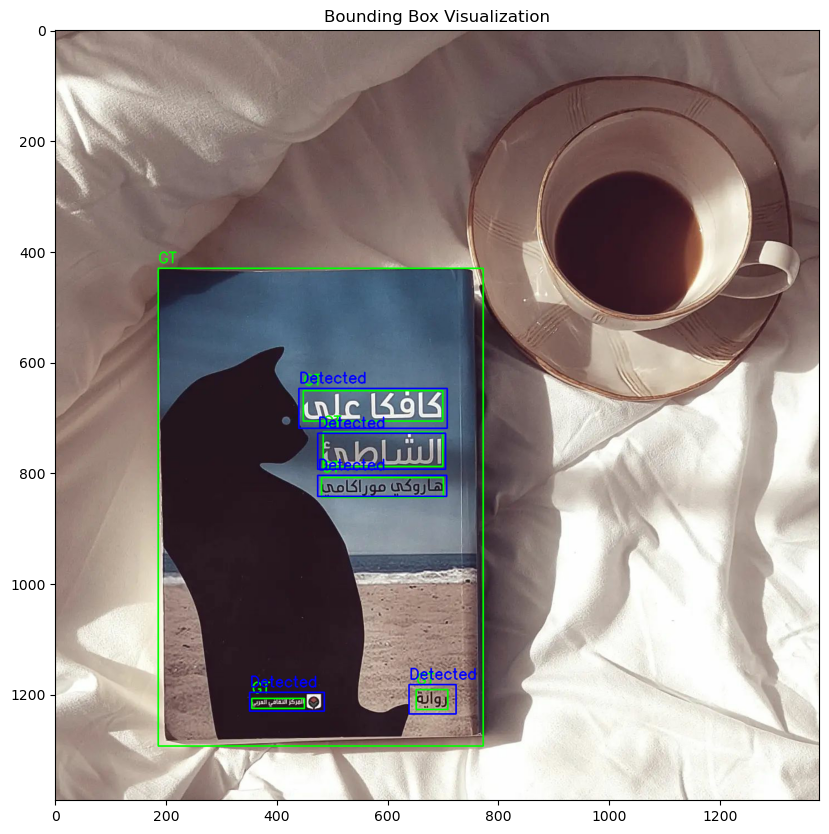

In [70]:
# Display the annotated image with bounding boxes
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.title("Bounding Box Visualization")
plt.show()

## Preprocessing: Cropping Bounding Boxes

In [22]:
def find_image_path(base_folder, base_filename, extensions):
    """
    Find the path of an image file with a given base filename and possible extensions.

    Parameters:
    base_folder : str
        The folder where the image file is located.
    base_filename : str
        The base name of the image file without extension.
    extensions : list
        A list of possible image file extensions.

    Returns:
    tuple
        A tuple containing the path of the found image and its extension, or (None, None) if not found.
    """
    for ext in extensions:
        image_path = os.path.join(base_folder, f"{base_filename}.{ext}")
        if os.path.exists(image_path):
            return image_path, ext
    return None, None

In [23]:
def crop_bounding_boxes(image_folder, annotations_folder, output_folder):
    """
    Crop bounding boxes from images based on coordinates provided in annotation files.

    Parameters:
    image_folder : str
        Folder containing the original images.
    annotations_folder : str
        Folder containing the annotation files with bounding box coordinates.
    output_folder : str
        Folder where cropped images will be saved.
    """
    os.makedirs(output_folder, exist_ok=True)
    extensions = ['jpg', 'jpeg', 'png']

    for filename in os.listdir(annotations_folder):
        if filename.endswith(".txt"):
            txt_path = os.path.join(annotations_folder, filename)
            with open(txt_path, 'r') as file:
                lines = file.readlines()

                base_filename = os.path.splitext(filename)[0]
                image_path, image_ext = find_image_path(image_folder, base_filename, extensions)

                if image_path:
                    image = cv2.imread(image_path)
                    if image is None or not image.size:
                        print(f"Failed to load image: {image_path}")
                        continue

                    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

                    for i, line in enumerate(lines):
                        coords = [int(x) for x in line.split(',')[:-1]]  # Exclude the label
                        x_coords, y_coords = coords[0::2], coords[1::2]
                        x_min, y_min = min(x_coords), min(y_coords)
                        x_max, y_max = max(x_coords), max(y_coords)

                        if 0 <= x_min < x_max <= image.width and 0 <= y_min < y_max <= image.height:
                            cropped_image = image.crop((x_min, y_min, x_max, y_max))
                            output_filename = f"{base_filename}_{i}.{image_ext}"
                            output_path = os.path.join(output_folder, output_filename)
                            cropped_image.save(output_path)
                        else:
                            print(f"Invalid cropping coordinates for file: {filename}")
                else:
                    print(f"No matching image file found for JSON file: {filename}")

In [24]:
# Define the directory containing the original images
image_folder = "out_vis_dir/"

# Define the directory containing annotation files with bounding box coordinates
annotations_folder = "out_txt_dir/"

# Define the output directory where the cropped images will be saved
output_folder = "cropped/"

# Call the function to crop bounding boxes from images based on the annotations
crop_bounding_boxes(image_folder, annotations_folder, output_folder)

Invalid cropping coordinates for file: 00839.txt
Invalid cropping coordinates for file: 00810.txt
Invalid cropping coordinates for file: 00623.txt
Invalid cropping coordinates for file: 00623.txt
Invalid cropping coordinates for file: 00145.txt
Invalid cropping coordinates for file: 00145.txt
Invalid cropping coordinates for file: 00621.txt
No matching image file found for JSON file: 00812.txt
Invalid cropping coordinates for file: 00806.txt
Invalid cropping coordinates for file: 00379.txt
Invalid cropping coordinates for file: 00386.txt
Invalid cropping coordinates for file: 00386.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00393.txt
Invalid cropping coordinates for file: 00436.txt
Invalid cropping coordinates for file: 00191.txt
Invalid cropping coordinates for file: 00191.txt
Invalid cropping coordinates for file: 00191.txt
Invalid croppin

## Preprocessing: Greyscaling, Enhancing Contrast, Binarization, Noise Removal

In [25]:
# Define the paths
cropped_images_folder = 'cropped/'
new_prep_folder = 'Preprocessed/'

# Create the new_prep folder if it doesn't exist
if not os.path.exists(new_prep_folder):
    os.makedirs(new_prep_folder)

In [26]:
def preprocess_image_for_ocr(image):
    """
    Preprocess an image to enhance it for OCR (Optical Character Recognition).

    Parameters:
    image : np.array
        The image to preprocess.

    Returns:
    np.array
        The preprocessed image.
    """
    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Mild contrast enhancement
    alpha = 1.3  # Contrast control (1.0-3.0)
    beta = 0     # Brightness control (0-100)
    adjusted_contrast = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)

    # Binarization using Otsu's thresholding
    _, binary_img = cv2.threshold(adjusted_contrast, 0, 255, 
                                  cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Noise removal using median blur
    denoised_img = cv2.medianBlur(binary_img, 3)

    return denoised_img

In [27]:
# Process each cropped image
for filename in os.listdir(cropped_images_folder):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(cropped_images_folder, filename)
        image = cv2.imread(image_path)

        # Preprocess the image for OCR
        preprocessed_image = preprocess_image_for_ocr(image)

        # Save the preprocessed image
        preprocessed_image_path = os.path.join(new_prep_folder, filename)
        cv2.imwrite(preprocessed_image_path, preprocessed_image)

## Applying Tesseract OCR on preprocessed images

In [28]:
def extract_arabic_from_json(json_data):
    """
    Extract Arabic values from JSON data.

    Parameters:
    json_data : dict
        The JSON data from which Arabic values are to be extracted.

    Returns:
    list
        A list of Arabic values extracted from the JSON data.
    """
    arabic_values = []
    for obj in json_data["objects"]:
        for tag in obj.get("tags", []):
            if tag.get("name") == "Transcription":
                arabic_values.append(tag.get("value"))
    return arabic_values

In [29]:
def write_to_file(arabic_values, file_path):
    """
    Write Arabic values to a text file.

    Parameters:
    arabic_values : list
        A list of Arabic values to be written to the file.
    file_path : str
        Path of the file where Arabic values will be written.
    """
    with open(file_path, "a", encoding="utf-8") as file:  # 'a' mode for appending
        for value in arabic_values:
            file.write(value + "\n")

In [30]:
def process_folder(folder_path, output_file_path):
    """
    Process all JSON files in a folder to extract and write Arabic values.

    Parameters:
    folder_path : str
        Path of the folder containing JSON files.
    output_file_path : str
        Path of the output text file where extracted Arabic values will be written.
    """
    for filename in os.listdir(folder_path):
        if filename.endswith(".json"):
            file_path = os.path.join(folder_path, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                json_data = json.load(file)
                arabic_values = extract_arabic_from_json(json_data)
                write_to_file(arabic_values, output_file_path)

In [31]:
# Folder containing JSON files and Output file path
json_folder_path = "ann/"  # Change to your folder path
output_file_path = "arabic_text_combined.txt"  # Output file path

# Process the folder
process_folder(json_folder_path, output_file_path)

### Environment Setup for Tesseract Arabic OCR
To run Tesseract OCR, the following commands were used to set up the environment with Arabic language support:

First, install Tesseract OCR and the language support using Homebrew (on macOS):

```bash
brew install tesseract
brew install tesseract-lang  # This installs language support including Arabic
pip install pytesseract
import pytesseract
pytesseract.pytesseract.tesseract_cmd = '/opt/homebrew/bin/tesseract'  # Adjust this path as needed
# Uncomment and set the appropriate path for your Tesseract data
# os.environ["TESSDATA_PREFIX"] = "/path/to/your/tesseract/data"

### Cloning the Necessary GitHub Repository
The project relies on specific code/data available in a GitHub repository. Clone the repository using the following commands:

```bash
git clone https://github.com/tesseract-ocr/langdata.git
git clone https://github.com/astutejoe/tesseract_tutorial.git
```

The first repo contains Arabic data that was used in training the Tesseract OCR model

The 'split_training_text.py' script from the second repo was modified to fit our specific requirements. The script was edited to include custom parameters tailored to our dataset and training process.
In our case, a font was specified as a parameter, after which the sentences in the training data, 'arabic_text_combined.txt', were converted to images of those sentences in that font, and used for training the model on them.

The following command was run to train the data with a max of 5k iterations:

```bash
TESSDATA_PREFIX=../tesseract/tessdata make training MODEL_NAME=arab START_MODEL=ara3 TESSDATA=../tesseract/tessdata MAX_ITERATIONS=5000
```


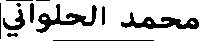

محمد الحلواني



In [86]:
# Set the TESSDATA prefix to the location of the Tesseract model data

# Baseline model
os.environ["TESSDATA_PREFIX"] = "tesseract_tutorial/tesseract/tessdata"

# Test a single image

# Load an image from file
image_path = 'Preprocessed/00711_3.jpg'
image = Image.open(image_path)

# Use Tesseract to perform OCR on the image with Arabic language
text = pytesseract.image_to_string(image, lang='ara')

# Display the image
display(image)

# Print the extracted text
print(text)


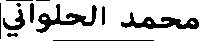

محمد الحلواني )



In [50]:
# Set the TESSDATA prefix to the location of the Tesseract model data

# Trained model
os.environ["TESSDATA_PREFIX"] = "tesseract_tutorial/tesstrain/data"

# Test a single image

# Load an image from file
image_path = 'Preprocessed/00711_3.jpg'
image = Image.open(image_path)

# Use Tesseract to perform OCR on the image with Arabic language (lang='ara2')
text = pytesseract.image_to_string(image, lang='ara3')

# Display the image
display(image)

# Print the extracted text
print(text)

In [51]:
# Perform Tesseract OCR on dataset

# Set the TESSDATA prefix to the location of the Tesseract trained model data
os.environ["TESSDATA_PREFIX"] = "/Users/z11241/Desktop/out_results/tesseract_tutorial/tesstrain/data"

def perform_ocr_on_directory(image_dir, output_dir):
    """
    Perform OCR on all images in a directory and save the extracted text to files.

    Parameters:
    image_dir : str
        The directory containing images to process.
    output_dir : str
        The directory where the extracted text files will be saved.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Loop through all files in the image directory
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            try:
                # Load the image
                image_path = os.path.join(image_dir, filename)
                image = Image.open(image_path)

                # Perform OCR using Tesseract
                text = pytesseract.image_to_string(image, lang='ara3')

                # Save the extracted text to a file
                output_file_path = os.path.join(output_dir, os.path.splitext(filename)[0] + '.txt')
                with open(output_file_path, 'w', encoding='utf-8') as file:
                    file.write(text)

            except Exception as e:
                print(f"Error processing {filename}: {e}")

In [52]:
# Directory containing images and destination directory for text output
image_directory = 'Preprocessed/'
output_directory = 'OCR_out/'
perform_ocr_on_directory(image_directory, output_directory)

## Evaluate OCR Results

In [53]:
def process_json_file(file_path, output_dir):
    """
    Process a JSON file to extract bounding box data and save it to a text file.

    Parameters:
    file_path : str
        Path to the JSON file to be processed.
    output_dir : str
        Directory where the output text files will be saved.
    """
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        base_name = os.path.splitext(os.path.basename(file_path))[0]
        output_file_path = os.path.join(output_dir, f"{base_name}.txt")

        with open(output_file_path, 'w', encoding='utf-8') as output_file:
            for obj in data['objects']:
                points = obj['points']['exterior']
                # Format: x1,y1,x2,y2,x3,y3,x4,y4,label
                formatted_points = ','.join(f"{x},{y}" for x, y in points) + ",1"
                output_file.write(formatted_points + "\n")

In [55]:
# Output gt bounding boxes 

def process_directory(directory, output_dir):
    """
    Process all JSON files in a directory, extracting bounding box data.

    Parameters:
    directory : str
        The directory containing JSON files to process.
    output_dir : str
        The directory where output text files will be saved.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(directory):
        if filename.endswith('.json'):
            file_path = os.path.join(directory, filename)
            process_json_file(file_path, output_dir)

In [ ]:
# Directory containing JSON files and the output directory

json_directory = "ann/"
output_directory = "gt_bb/"
process_directory(json_directory, output_directory)

In [56]:
# Output gt text

def extract_ground_truth_texts(json_dir):
    """
    Extract ground truth texts from JSON files in a directory.

    Parameters:
    json_dir : str
        The directory containing JSON files.

    Returns:
    list
        A list of extracted ground truth texts.
    """
    ground_truth_texts = []

    for filename in os.listdir(json_dir):
        if filename.lower().endswith('.json'):
            file_path = os.path.join(json_dir, filename)

            with open(file_path, 'r', encoding='utf-8') as file:
                data = json.load(file)

                for obj in data['objects']:
                    # Check if 'tags' exist and contain 'Transcription'
                    if 'tags' in obj:
                        for tag in obj['tags']:
                            if tag['name'] == 'Transcription':
                                ground_truth_texts.append(tag['value'])

    return ground_truth_texts

In [57]:
json_directory = 'ann/' 
extracted_texts = extract_ground_truth_texts(json_directory)

# For demonstration, print the extracted texts
for text in extracted_texts:
    print(text)

ما بعد العقل الواعي
تفسيرُ الأحلَام
الكَبير
قصة
مدينتين
زنقة 
الطّليان
الإعلام الدرامي
بين الواقع و المأمول 
مناهج المواد و المجالات العلمية 
السيرة النبوية
المرجع الجامع 
في
كمايات منهج اللغة العربية
يوم غضبت 
صور
القدود
كيف تطيل عمرك الانتاجي
اللِصّ وَ الكِلاب
الدعَاء هو العبَادة
سفينة في البحر الهائج
كيف تطيل عمرك الانتاجي
فتية الإسلام 
أحبَبت وغْداً
سما نغم
وحي الغربة
إلى شرح قطر النًدى
مجيب النًدا
الهاشميون
السيرة النبوية
هزار و زهرة اللوتس
 مرض النزيف
أشهر ٥٠ خرافة
فى علم النفس
فن الحب
المال
: المجتَمع
بَتيَة وَحَركَة
صيدلية
الأعشاب
تفسير الأحلام
فصٌول النَار
شخصيّات من ورق
مبادئ
القواعد والإملاء
العملاق والقط الذكي
المتقن
زَمَنٌ الخٌيول البَيضاء
رواية
تكوين النسق الفلسفي
دراسات
مَهزلة العَقل اَلبَشري
السَّببيَّة
برامج التلفزيون
صالح سليم
دين الحق
 سلسلة في التربية الإسلامية
 نحو بناء جيل يحمل رسالة الإسلام السمحة
القوة
مقابل
الإكراه
مستقبل
الديمقراطية 
الاجتماعية
دبابيس
ياسَمين  
العَودَة
يا بنتي
العقل المستقيل
و القطعية المعرفية
تألّق
وأبدِع
نظرية التنظيم
المفيدْ
في الأدَبِ الع

In [73]:
# Set environment variable for Tesseract
os.environ["TESSDATA_PREFIX"] = "tesseract_tutorial/tesseract/tessdata"

def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters:
    box1 (tuple): A tuple of (x_min, y_min, x_max, y_max) for the first box.
    box2 (tuple): A tuple of (x_min, y_min, x_max, y_max) for the second box.

    Returns:
    float: The IoU between the two bounding boxes.
    """
    poly1 = Polygon([(box1[0], box1[1]), (box1[2], box1[1]), (box1[2], box1[3]), (box1[0], box1[3])])
    poly2 = Polygon([(box2[0], box2[1]), (box2[2], box2[1]), (box2[2], box2[3]), (box2[0], box2[3])])
    iou = poly1.intersection(poly2).area / poly1.union(poly2).area
    return iou

def find_image_path(image_dir, base_filename):
    """
    Find the full path of an image given the directory and the base filename.

    Parameters:
    image_dir (str): The directory where images are stored.
    base_filename (str): The base name of the image file, without extension.

    Returns:
    str or None: The full path to the image if found, otherwise None.
    """
    for extension in ['.jpg', '.jpeg', '.png']:
        image_path = os.path.join(image_dir, base_filename + extension)
        if os.path.exists(image_path):
            return image_path
    return None

def preprocess_image_for_ocr(image):
    """
    Preprocess an image for optical character recognition (OCR).

    The preprocessing steps include conversion to grayscale, contrast adjustment,
    binarization, and noise removal.

    Parameters:
    image (PIL.Image): The image to preprocess.

    Returns:
    PIL.Image: The preprocessed image ready for OCR.
    """
    gray_image = cv2.cvtColor(cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR), cv2.COLOR_BGR2GRAY)
    alpha, beta = 1.3, 0  # Contrast and brightness control
    adjusted_contrast = cv2.convertScaleAbs(gray_image, alpha=alpha, beta=beta)
    _, binary_img = cv2.threshold(adjusted_contrast, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    denoised_img = cv2.medianBlur(binary_img, 3)
    return Image.fromarray(cv2.cvtColor(denoised_img, cv2.COLOR_BGR2RGB))

In [74]:
# Define directories
output_files_dir = 'out_txt_dir/'
ground_truth_files_dir = 'ann/'
image_dir = 'img/'

### Calculate overall metrics of Tesseract OCR on preprocessed images

In [88]:
# Initialize metrics
true_positives, false_positives, false_negatives = 0, 0, 0
ious = []

# Iterate over output files
idx= 0
distances = []
accuracies = []
for filename in os.listdir(output_files_dir):
    if filename.endswith('.txt'):
        # Construct paths to the output and corresponding ground truth file
        output_file_path = os.path.join(output_files_dir, filename)
        ground_truth_file_path = os.path.join(ground_truth_files_dir, filename.replace('.txt', '.json'))

        # Skip if ground truth file does not exist
        if not os.path.exists(ground_truth_file_path):
            continue

        # Load ground truth data
        with open(ground_truth_file_path, 'r') as gt_file:
            ground_truth_data = json.load(gt_file)

        # Convert ground truth polygons to bounding boxes
        ground_truth_boxes = []
        for obj in ground_truth_data['objects']:
            tags = obj['tags']
            points = obj['points']['exterior']
            xs, ys = zip(*points)
            x_min, x_max = min(xs), max(xs)
            y_min, y_max = min(ys), max(ys)
            ground_truth_boxes.append({'tags':tags,'bbox':(x_min, y_min, x_max, y_max)})

        # Load output bounding boxes
        output_boxes = []

        base_image_file = os.path.basename(ground_truth_file_path).replace('.json', '')
        image_path = find_image_path(image_dir, base_image_file)
        # print(image_path)
        image = Image.open(image_path)

        if not image_path:
            print(f"Image file for {ground_truth_file_path} not found.")
            raise("Error")


        with open(output_file_path, 'r') as out_file:
            for line in out_file:
                x1, y1, x2, y2, x3, y3, x4, y4, _ = map(int, line.split(','))
                x_min, x_max = min(x1, x2, x3, x4), max(x1, x2, x3, x4)
                y_min, y_max = min(y1, y2, y3, y4), max(y1, y2, y3, y4)
                output_boxes.append((x_min, y_min, x_max, y_max))

        # Calculate metrics for each file
        iou_threshold = 0.5
        file_true_positives, file_false_positives, file_false_negatives = 0, 0, 0

        for gt_box_dict in ground_truth_boxes:
            matched = False
            for out_box in output_boxes:
                gt_box = gt_box_dict['bbox']
                tags = gt_box_dict['tags']
                iou = calculate_iou(gt_box, out_box)
                if iou >= iou_threshold:
                    file_true_positives += 1
                    ious.append(iou)
                    matched = True

                    idx += 1
                    if len(tags) > 0 :
                      gt_text = tags[0]['value']
                      cropped_image = image.crop(out_box)
                      preprocessed_img = preprocess_image_for_ocr(cropped_image)
                      preprocessed_img.save(f'preprocessed/{base_image_file}_{idx}.jpg')
                      pred_text = pytesseract.image_to_string(preprocessed_img, lang='ara') # model to be evaluated
                      print(pred_text,"   xx  " ,gt_text)
                      distance = editdistance.eval(pred_text, gt_text)
                      print('Current Distance : ',distance)
                      distances.append(distance)
                      accuracies.append(max(0, 1 - distance / len(gt_text)))


                    break
            if not matched:
                file_false_negatives += 1

        file_false_positives = len(output_boxes) - file_true_positives

        true_positives += file_true_positives
        false_positives += file_false_positives
        false_negatives += file_false_negatives


    xx   معركة السلام
Current Distance :  12
4
وي ُُ ب 7 و
أي أ م 0
ناب : ٌّّ"
سس © عس ا
    xx   فقه العبادات
Current Distance :  40
زول يا ملك الزكات
    xx   الفيل يا ملك الزمان
Current Distance :  7
د
0
0
    xx   بنات الرسول صل الله عليه وسلم
Current Distance :  29
الحدا

له
    xx   الحداثة
Current Distance :  5
بل
    xx   رحلات
Current Distance :  4
حلاصب
    xx   فِقهُ العِبادَات
Current Distance :  14
انرس الطالِبٌ
    xx   قامُوسْ الطالِبْ
Current Distance :  7
الازدن: تؤار بلا نورة
    xx   الأردن: ثوّار بلا ثورة
Current Distance :  7
    xx   ألم نشرح لك صدرك
Current Distance :  16
    xx   فاتتني صلاة
Current Distance :  11
وهاه
    xx   الحارس والحصان
Current Distance :  13
    xx   بَنكْ الجُمهورِيّة
Current Distance :  18
    xx   كنوُز الفَنّ الكُوَيْتيّ المُعَاصِرْة
Current Distance :  37
    xx   أحبَبت وغْداً
Current Distance :  13
الدراسَات الاصة
    xx   الدًرَاسَاتُ اﻷدَبيًة 
Current Distance :  10
في الاين العربية والمارسية وتفاغلهما
    xx   في الثقافتًين العر

In [89]:
# Calculate overall metrics of the OCR on preprocessed images

precision = true_positives / (true_positives + false_positives) if true_positives + false_positives else 0
recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives else 0
f1_score = 2 * precision * recall / (precision + recall) if precision + recall else 0
average_iou = sum(ious) / len(ious) if ious else 0

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1_score}")
print(f"Average IoU: {average_iou}")

# OCR Evaluation
print(f'Total distance: {sum(distances)}')
print(f'Average Accuracy: {sum(accuracies) / len(accuracies) * 100:.2f}%')

Precision: 0.72083197920052
Recall: 0.35733848880296437
F1 Score: 0.4778112882378284
Average IoU: 0.7821017796934308
Total distance: 4848
Average Accuracy: 27.28%


In [106]:
def calculate_edit_distance(str1, str2):
    """
    Calculate the edit distance between two strings.

    Parameters:
    str1 (str): First string.
    str2 (str): Second string.

    Returns:
    int: The edit distance between str1 and str2.
    """
    return editdistance.eval(str1, str2)

def calculate_accuracy(ocr_text, ground_truth):
    """
    Calculate the accuracy of OCR text compared to the ground truth.

    Parameters:
    ocr_text (str): Text extracted by OCR.
    ground_truth (str): The ground truth text.

    Returns:
    float: The accuracy of the OCR text.
    """
    correct = sum(1 for a, b in zip(ocr_text, ground_truth) if a == b)
    return correct / len(ground_truth) if ground_truth else 0

### Compare OCR results between raw images vs TCM-CLIP preprocessed images

In [107]:
# Calculate OCR metrics of raw preprocessed images

def process_images(image_dir, json_dir, single_json_per_image=False):
    """
    Process images for OCR, compare with ground truth, and calculate metrics.

    Parameters:
    image_dir (str): Directory containing images.
    json_dir (str): Directory containing ground truth JSON files.
    single_json_per_image (bool): Flag to indicate processing mode.

    Returns:
    dict: A dictionary containing average accuracy and edit distance.
    """
    accuracies, distances = [], []
    allowed_extensions = {".png", ".jpg", ".jpeg", ".bmp", ".tiff", ".tif"}

    for image_filename in os.listdir(image_dir):
        if image_filename.lower().endswith(tuple(allowed_extensions)):
            image_path = os.path.join(image_dir, image_filename)
            ocr_text = perform_ocr_on_image(image_path)

            if single_json_per_image:
                base_name = image_filename.split('_')[0]
                json_file_path = os.path.join(json_dir, base_name + '.json')
                if os.path.isfile(json_file_path):
                    ground_truth_texts = extract_ground_truth_texts(json_file_path)
            else:
                ground_truth_texts = extract_ground_truth_texts(json_dir)

            for gt_text in ground_truth_texts:
                edit_distance = calculate_edit_distance(ocr_text, gt_text)
                distances.append(edit_distance)
                accuracy = calculate_accuracy(ocr_text, gt_text)
                accuracies.append(accuracy)

    average_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0
    average_distance = sum(distances) / len(distances) if distances else 0
    return {"average_accuracy": average_accuracy, "average_edit_distance": average_distance}

In [109]:
# Calculate OCR metrics of raw preprocessed images

image_directory = "img/"
json_directory = "ann/"
ocr_metrics = process_images(image_directory, json_directory)

print(f"Average Accuracy: {ocr_metrics['average_accuracy']:.2f}")
print(f"Average Edit Distance: {ocr_metrics['average_edit_distance']:.2f}")

Average Accuracy: 0.03
Average Edit Distance: 70.52


In [110]:
# Calculate OCR metrics of TCM-CLIP preprocessed images

image_directory = "cropped/"
json_directory = "ann/"
ocr_metrics = process_images(image_directory, json_directory)

print(f"Average Accuracy: {ocr_metrics['average_accuracy']:.2f}")
print(f"Average Edit Distance: {ocr_metrics['average_edit_distance']:.2f}")

Average Accuracy: 0.03
Average Edit Distance: 18.09
